## City of LA - Making sense of this mess!

## Hypothesis : 

## Adjusting the readability-level of job postings based on education requirements of that post will increase interest in job postings for those limited written English comprehension skills.

Upon initial analysis, the very first job text was at the 23rd and 24th grade level!!!!   A Painter.  I don't think that is reasonable to expect your average painter to be able to read at a post-doc level!

It's no suprise they might have trouble attracting talent

Right now all I want to do is pull in some of the documents and see what I'm dealing with:
* Reading in the job bulletin text files
* Reading in the PDFs


#### Packages to import.   Custom import required

 PyPDF2    https://pythonhosted.org/PyPDF2/PdfFileReader.html
 
 textstat https://pypi.org/project/textstat/

In [41]:
%matplotlib inline

!pip install PyPDF2
!pip install textstat
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory

import os
import re #search in strings.

import plotly.plotly as py
import cufflinks as cf

import seaborn as sns
import matplotlib.pyplot as plt

import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go
import plotly.tools as tls

from wordcloud import WordCloud

You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
You are using pip version 19.0.3, however version 19.1.1 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.


## Load file titles

In [42]:
input_dir = '../input/cityofla/CityofLA/Job Bulletins/'

def getListOfFiles(dirName):
# create a list of file and sub directories 
# names in the given directory 
    listOfFile = os.listdir(dirName)
    allFiles = list()
    # Iterate over all the entries
    for entry in listOfFile:
    # Create full path
        fullPath = os.path.join(dirName, entry)
        # If entry is a directory then get the list of files in this directory 
        if os.path.isdir(fullPath):
            allFiles = allFiles + getListOfFiles(fullPath)
        else:
            allFiles.append(fullPath)
    return allFiles
listOfFiles = getListOfFiles(input_dir)
df_bulletins = pd.DataFrame(listOfFiles, columns = ['job_position'])
df_bulletins.head()

,job_position
0,../input/cityofla/CityofLA/Job Bulletins/ARTS ...
1,../input/cityofla/CityofLA/Job Bulletins/SENIO...
2,../input/cityofla/CityofLA/Job Bulletins/SENIO...
3,../input/cityofla/CityofLA/Job Bulletins/WASTE...
4,../input/cityofla/CityofLA/Job Bulletins/SENIO...


### Clean up the file names

In [43]:
# Clean up of the job_position name
df_positions = pd.DataFrame()
df_positions['job_position'] = (df_bulletins['job_position']
                                .str.replace(input_dir, '', regex=False)
                                .str.replace('.txt', '', regex=False)
                                .str.replace('\d+', '')
                                .str.replace(r"\s+\(.*\)","")
                                .str.replace(r"REV",""))

#Remove the numbers
df_positions['class_code'] = (df_bulletins['job_position']
                              .str.replace(input_dir, '', regex=False)
                              .str.replace('.txt', '', regex=False)
                              .str.extract('(\d+)'))

display(df_positions.head())
# Add the Text fields of Salary, Duties and Minimum REQ


,job_position,class_code
0,ARTS ASSOCIATE,2454
1,SENIOR COMMUNICATIONS ELECTRICIAN,3638
2,SENIOR AUTOMOTIVE SUPERVISOR,3716
3,WASTEWATER COLLECTION WORKER,4110
4,SENIOR STOREKEEPER,1837


### Convert the information in the txt files in a table


In [44]:
#Convert the txt files to a table:
import glob
path = input_dir # use your path
all_files = glob.glob(path + "/*.txt")
li = []

for filename in all_files:
    with open (filename, "r",errors='replace') as myfile:
        data=pd.DataFrame(myfile.readlines())
        #df = pd.read_csv(filename, header=0,error_bad_lines=False, encoding='latin-1')
    li.append(data)
frame = pd.concat(li, axis=1, ignore_index=True)
#pd.read_csv(listOfFiles,header = None)
frame = frame.replace('\n','', regex=True)


Look for keywords, and append the following strings to the final dataframe

In [45]:
# Here the loop should start, for each text file do:
def getString(col_i, frame):
    try:
        filter = frame[col_i] != ""
        bulletin = frame[col_i][filter]
        #display(salary)
        isal = min(bulletin[bulletin.str.contains('SALARY',na=False)].index.values) #take the sum to convert the array to an int...TO CHANGE
        inot = min(bulletin[bulletin.str.contains('NOTES',na=False)].index.values) # NOTES
        idut = min(bulletin[bulletin.str.contains('DUTIES',na=False)].index.values) # DUTIES
        ireq = min(bulletin[bulletin.str.contains('REQUIREMENT',na=False)].index.values) #REQUIREMENTS
        ipro = min(bulletin[bulletin.str.contains('PROCESS',na=False)].index.values) # PROCESS NOTES

        #isal = sum(bulletin.loc[bulletin == 'ANNUAL SALARY'].index.values) #take the sum to convert the array to an int...TO CHANGE
        #inot = sum(bulletin.loc[bulletin == 'NOTES:'].index.values) # NOTES
        #idut = sum(bulletin.loc[bulletin == 'DUTIES'].index.values) # DUTIES
        #ireq = sum(bulletin.loc[bulletin == '(.*)REQUIREMENTS(.*)'].index.values) #REQUIREMENTS
        #ipro = sum(bulletin.loc[bulletin == '(.*)PROCESS(.*)'].index.values) # PROCESS NOTES

        icode = min(bulletin[bulletin.str.contains('Class Code',na=False)].index.values)
        class_code = sum(bulletin.str.extract('(\d+)').iloc[icode].dropna().astype('int'))
        salary = (bulletin.loc[isal+1:inot-1]).to_string()
        duties = (bulletin.loc[idut+1:ireq-1]).to_string()
        requirements = (bulletin.loc[ireq+1:ipro-1]).to_string()
        return (class_code, salary, duties, requirements)
    except:
        return (np.nan,np.nan,np.nan,np.nan)
    
jobsections = pd.DataFrame()
#getString(0,bulletin)
for col_i in range(frame.shape[1]):
    #print(col_i)
    #print(list(getString(col_i,frame)))
    prop = getString(col_i,frame)
    prop = pd.DataFrame(list(prop)).T
    jobsections = jobsections.append(prop)

In [46]:
jobsections.head()

,0,1,2,3
0,2454,"7 $48,797 to $71,326",16 An Arts Associate performs a broad range...,21 1. A bachelor's degree from an accredite...
0,3,"8 $94,941 (Fla...",18 A Senior Communications Electrician acts...,22 Two years of full-time paid experience i...
0,3716,"7 $103,126 and $111,875 (fl...",15 A Senior Automotive Supervisor assists i...,18 ...
0,10,"9 $43,973 to $62,556, $50,634 to $72,077 an...",18 A Wastewater Collection Worker performs ...,26 1. One year of full-time paid experience...
0,5,"8 $52,806 to $77,172 The salary range in th...","18 A Senior Storekeeper assigns, reviews an...",22 Two years of full-time paid experience a...


In [47]:
jobsections.columns = ['class_code','salary','duties','requirements']
jobsections['class_code'] = pd.to_numeric(jobsections['class_code'],downcast='integer')
df_positions['class_code'] = pd.to_numeric(df_positions['class_code'], downcast='integer')
#df_positions['class_code']
df_jobs = df_positions.merge(jobsections, left_on='class_code',right_on='class_code', how='outer')
display(df_jobs.dropna())


,job_position,class_code,salary,duties,requirements
0,ARTS ASSOCIATE,2454.0,"7 $48,797 to $71,326",16 An Arts Associate performs a broad range...,21 1. A bachelor's degree from an accredite...
2,SENIOR AUTOMOTIVE SUPERVISOR,3716.0,"7 $103,126 and $111,875 (fl...",15 A Senior Automotive Supervisor assists i...,18 ...
9,BUILDING REPAIRER,3333.0,"8 $44,411 to $64,915 and $47,940 to...",19 A Building Repairer does a variety of ma...,23 Three years of full-time paid experience...
12,LAND SURVEYING ASSISTANT,7283.0,"9 $66,440 t...",20 A Land Surveying Assistant sets up and o...,25 1. Graduation from an accredited college...
13,TRAFFIC OFFICER,3214.0,"7 $45,017 to $48,838; $44,808 to $63,767; a...",18 A Traffic Officer patrols an assigned ar...,26 1. Graduation from high school or G.E.D....
16,ELECTRICAL TESTER,7512.0,6 ...,17 An entry-level Electrical Tester receive...,21 1. Six months of full-time paid experien...
19,ARCHIVIST,1191.0,"7 $57,273 to $83,728 and $67,818 to $99,159",16 An Archivist performs professional archi...,20 1. A bachelor's degree from an accredite...
21,PROPERTY MANAGER,1964.0,"7 $95,088 to $135,282; $105,695 to $150,378...","18 A Property Manager plans and directs, or...",22 1. Two years of full-time paid experienc...
26,POLICE LIEUTENANT,2232.0,"6 $125,572 to $139,916 and $132,546 to...","15 A Police Lieutenant plans, organizes, an...","19 1. Two years as a Police Sergeant, Polic..."
27,FLEET SERVICES MANAGER,9103.0,"7 $100,203 to $124,507; $112,062 to $139,22...","18 A Fleet Services Manager plans, manages,...",22 1. Three years of full-time paid experie...


# Requirements word cloud

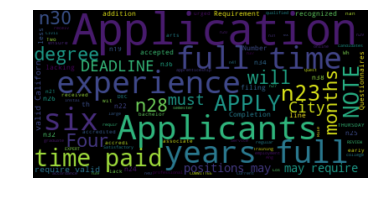

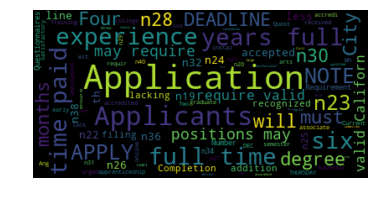

In [48]:


from os import path
from wordcloud import WordCloud

# Read the whole text.
text = df_jobs['requirements'].values

text = str(text)


# Generate a word cloud image
wordcloud = WordCloud().generate(text)

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

1. # Duties Wordcloud

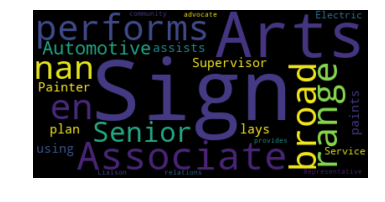

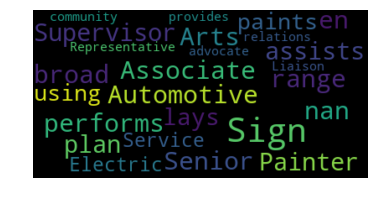

In [49]:
# Read the whole text.
text = df_jobs['duties'].values

text = str(text)


# Generate a word cloud image
wordcloud = WordCloud().generate(text)

# Display the generated image:
# the matplotlib way:
import matplotlib.pyplot as plt
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")

# lower max_font_size
wordcloud = WordCloud(max_font_size=40).generate(text)
plt.figure()
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.show()

![](http://)# Let's look at the pdfs


In [50]:
import PyPDF2   #https://pythonhosted.org/PyPDF2/PdfFileReader.html

# Get the pdf files.
input_dir = '../input/cityofla/CityofLA/Additional data/PDFs/'

listOfFiles = getListOfFiles(input_dir)
listOfFiles


['../input/cityofla/CityofLA/Additional data/PDFs/2018/December/Dec 7/SENIOR PERSONNEL ANALYST 9167 120718.pdf',
 '../input/cityofla/CityofLA/Additional data/PDFs/2018/December/Dec 7/COMMERCIAL FIELD REPRESENTATIVE 1600 120718.pdf',
 '../input/cityofla/CityofLA/Additional data/PDFs/2018/December/Dec 7/HARBOR ENGINEER 9279 120718.pdf',
 '../input/cityofla/CityofLA/Additional data/PDFs/2018/December/Dec 7/Job 12072018 Summary.pdf',
 '../input/cityofla/CityofLA/Additional data/PDFs/2018/December/Dec 7/CITY PLANNER 7944 120718.pdf',
 '../input/cityofla/CityofLA/Additional data/PDFs/2018/December/Dec 7/WASTEWATER TREATMENT OPERATOR 120718.pdf',
 '../input/cityofla/CityofLA/Additional data/PDFs/2018/December/Dec 14/MECHANICAL ENGINEERING DRAFTING TECHNICIAN 7551 121418.pdf',
 '../input/cityofla/CityofLA/Additional data/PDFs/2018/December/Dec 14/SENIOR SECURITY OFFICER 3184 121418.pdf',
 '../input/cityofla/CityofLA/Additional data/PDFs/2018/December/Dec 14/UNDERGROUND DISTRIBUTION CONSTRUCTIO

In [51]:
df_opening_pdfs = pd.DataFrame(listOfFiles, columns = ['opening_pdf'])
df_opening_pdfs.head()

# Clean up the pdf opening names

df_openings = pd.DataFrame()
df_openings['job_position'] = (df_opening_pdfs['opening_pdf']
                                .str.replace(input_dir, '', regex=False)
                                .str.replace('.txt', '', regex=False)
                                .str.replace('\d+', '')
                                .str.replace(r"\s+\(.*\)","")
                                .str.replace(r"REV",""))

#Remove the numbers
df_openings['class_code'] = (df_opening_pdfs['opening_pdf']
                              .str.replace(input_dir, '', regex=False)
                              .str.replace('.txt', '', regex=False)
                              .str.extract('(\d+)'))


df_openings['version'] =       df_opening_pdfs['opening_pdf'].str.slice(start=-10,stop=-4)

pdfFile = PyPDF2.PdfFileReader('../input/cityofla/CityofLA/Additional data/PDFs/2018/December/Dec 7/SENIOR PERSONNEL ANALYST 9167 120718.pdf', 'rb')
#pdfFile = df_opening_pdfs['opening_pdf']
metadata = pdfFile.getDocumentInfo()
metadata
#pdfReader = PyPDF2.PdfFileReader(pdfFileObj) 
#df_openings['info'] = pdfReader.getPage(1) 
                           
df_openings.head()
# Add the Text fields of Salary, Duties and Minimum REQ


#pdfFileObj = open('../input/CityofLA/CityofLA/Additional_data/PDFs/2018/February/Feb_2/SOLID_WASTE_DISPOSAL_SUPERINTENDENT_4108_020218.pdf','rb') #'rb' for read binary mode 
#pdfReader = PyPDF2.PdfFileReader(pdfFileObj) 
#pdfReader.numPages.pageObj = pdfReader.getPage(1) #'1' is the page number pageObj.extractText()

,job_position,class_code,version
0,/December/Dec /SENIOR PERSONNEL ANALYST .pdf,2018,120718
1,/December/Dec /COMMERCIAL FIELD REPRESENTATIVE...,2018,120718
2,/December/Dec /HARBOR ENGINEER .pdf,2018,120718
3,/December/Dec /Job Summary.pdf,2018,ummary
4,/December/Dec /CITY PLANNER .pdf,2018,120718


## What is the structure of the PDF?

In [52]:
pdfFile = PyPDF2.PdfFileReader('../input/cityofla/CityofLA/Additional data/PDFs/2018/December/Dec 7/SENIOR PERSONNEL ANALYST 9167 120718.pdf', 'rb')
#pdfFile = df_opening_pdfs['opening_pdf']
DocumentInfo = pdfFile.getDocumentInfo()
DocumentInfo

{'/Author': 'City of LA',
 '/Company': 'Personnel Department',
 '/CreationDate': "D:20181207070415-08'00'",
 '/Creator': 'Acrobat PDFMaker 19 for Word',
 '/Keywords': '',
 '/ModDate': "D:20181207073258-08'00'",
 '/Producer': 'Adobe PDF Library 19.8.103',
 '/SourceModified': 'D:20181205164808',
 '/Subject': '',
 '/Title': 'SENIOR PERSONNEL ANALYST'}

In [53]:
pdfFields = pdfFile.getNumPages()
pdfFields

2

In [54]:
pdfPageLayout = pdfFile.getPageLayout()
pdfPageLayout

'/OneColumn'

In [55]:
pdfPageMode = pdfFile.getOutlines()
pdfPageMode

[{'/Title': 'SENIOR PERSONNEL ANALYST',
  '/Page': {'/Annots': [IndirectObject(185, 0),
    IndirectObject(186, 0),
    IndirectObject(187, 0),
    IndirectObject(188, 0),
    IndirectObject(189, 0)],
   '/Contents': {'/Filter': '/FlateDecode'},
   '/CropBox': [0, 0, 612, 792],
   '/MediaBox': [0, 0, 612, 792],
   '/Parent': {'/Count': 2,
    '/Kids': [IndirectObject(167, 0), IndirectObject(1, 0)],
    '/Type': '/Pages'},
   '/Resources': {'/Font': {'/TT0': {'/BaseFont': '/FNQAGN+Arial-BoldMT',
      '/Encoding': '/WinAnsiEncoding',
      '/FirstChar': 32,
      '/FontDescriptor': {'/Ascent': 1018,
       '/CapHeight': 716,
       '/Descent': -376,
       '/Flags': 32,
       '/FontBBox': [-628, -376, 2000, 1018],
       '/FontFamily': 'Arial',
       '/FontFile2': {'/Filter': '/FlateDecode', '/Length1': 62054},
       '/FontName': '/FNQAGN+Arial-BoldMT',
       '/FontStretch': '/Normal',
       '/FontWeight': 700,
       '/ItalicAngle': 0,
       '/StemV': 136,
       '/Type': '/FontD

In [56]:
pdfFile.numPages 
pageObj = pdfFile.getPage(1)
pdftext= pageObj.extractText()

pdftext

'Class Code 9167 CONT. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .\n . . . . . . . . . . . . . . . . . . . . . . . . . . . 12\n-07-18 SELECTION\n PROCESS\n                          Examinati\non Weights:  \nEssay . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .\n . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . Advisory\n                                         Written Test\n  . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .Qualifying\n                                         Oral Presentation Exercise . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . \n. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .

# How do I run analysis on the text to acertain reading level?

https://www.geeksforgeeks.org/readability-index-pythonnlp/

To apply the formula:

Select several 100-word samples throughout the text.
Compute the average sentence length in words (divide the number of words by the number of sentences).
Compute the percentage of words NOT on the Dale–Chall word list of 3, 000 easy words.
Compute this equation

 Raw score = 0.1579*(PDW) + 0.0496*(ASL) + 3.6365
Here,
PDW = Percentage of difficult words not on the Dale–Chall word list.
ASL = Average sentence length
The Gunning fog Formula

Grade level= 0.4 * ( (average sentence length) + (percentage of Hard Words) )
Here, Hard Words = words with more than two syllables.
Smog Formula

SMOG grading = 3 + √(polysyllable count).
Here, polysyllable count = number of words of more than two syllables in a 
sample of 30 sentences.
Flesch Formula

Reading Ease score = 206.835 - (1.015 × ASL) - (84.6 × ASW)
Here,
ASL = average sentence length (number of words divided by number of sentences)
ASW = average word length in syllables (number of syllables divided by number of words)
Advantages of Readability Formulae:

1. Readability formulas measure the grade-level readers must have to be to read a given text. Thus provides the writer of the text with much needed information to reach his target audience.

2. Know Before hand if the target audience can understand your content.

3. Easy-to-use.

4. A readable text attracts more audience.

Disadvantages of Readability Formulae:

1. Due to many readability formulas, there is an increasing chance of getting wide variations in results of a same text.

2. Applies Mathematics to Literature which isn’t always a good idea.

3. Cannot measure the complexity of a word or phrase to pinpoint where you need to correct it.

In [57]:
import textstat

# 2018/December/Dec 7/SENIOR PERSONNEL ANALYST 9167 

test_data = (
    "The examination will consist of a qualifying multiple"
    "-choice test, an advisory essay, an advisory oral presentation, and an interview."
    " The qualifying written test will consist of "
    "multiple-choice questions in which emphasis may be placed on the candidate's expertise and knowledge of:"
    " Civil Service selection procedures; Equal Employment Opportunity "
    "(EEO) policies; Americans with Disabilities Act (ADA) regulations; Family and Medical Leave Act (FMLA); "
    "Fair Labor Standards Act (FLSA); and demonstrated proficiency and "
    "familiarity with the City's authoritative documents sufficient to identify the appropriate source, "
    "interpret complex written material, and effectively interpret provisions of the City Charter, "
    "Administrative Code, City Code of Ethics, Memoranda of Understandin (MOUs) provisions,"
    " Mayor's Executive Directives, and Personnel Department rules, policies and procedures, "
    "including Civil Service Commission (CSC) Rules, Personnel Department Policies and Personnel Department Procedures Manual; "
    "interpret complex data such as legislation, technical reports, and graphs; principles and practices of supervision,"
    " including training, counseling, and disciplining subordinate staff; and other necessary knowledge, skills, and abilities."
    "Prior to the multiple-choice test, applicants will be required to prepare some written material related to the work "
    "of a Senior Personnel Analyst employed by the City of Los Angeles. "
    "This essay material will not be separately scored, but will be presented to the interview board "
    "for discussion with the candidate and for consideration in the overall evaluation of the candidate's qualifications."
    "The advisory essay will be administered on-line. Candidates will receive an e-mail from the City of Los Angeles "
    "outlining the specific steps needed to complete the on-line advisory essay. "
    "Candidates will be required to complete the on-line advisory essay between FRIDAY, JANUARY 11, 2019 and "
    "SUNDAY, JANUARY 13, 2019. Additional instructions will be sent via e-mail. "
    "Candidates who fail to complete the advisory essay as instructed may be disqualified."
    "The multiple-choice test will be proctored and administered on-line during a single session. "
    "Candidates invited to participate in the on-line multiple-choice test will be able to take the test "
    "as instructed from a remote location using a computer with a webcam and a reliable internet connection. "
    "Candidates will receive an e-mail from the City of Los Angeles outlining the dates and "
    "specific steps on how to take the multiple-choice test and advisory essay on-line"
)

textstat.flesch_reading_ease(test_data)
textstat.smog_index(test_data)
textstat.flesch_kincaid_grade(test_data)
textstat.coleman_liau_index(test_data)
textstat.automated_readability_index(test_data)
textstat.dale_chall_readability_score(test_data)
textstat.difficult_words(test_data)
textstat.linsear_write_formula(test_data)
textstat.gunning_fog(test_data)
textstat.text_standard(test_data)

'23rd and 24th grade'

In [59]:
# Let's take another sample


df_opening_pdfs.head()

# Clean up the pdf opening names

df_openings = pd.DataFrame()
df_openings['job_position'] = (df_opening_pdfs['opening_pdf']
                                .str.replace(input_dir, '', regex=False)
                                .str.replace('.txt', '', regex=False)
                                .str.replace('\d+', '')
                                .str.replace(r"\s+\(.*\)","")
                                .str.replace(r"REV",""))

#Remove the numbers
df_openings['class_code'] = (df_opening_pdfs['opening_pdf']
                              .str.replace(input_dir, '', regex=False)
                              .str.replace('.txt', '', regex=False)
                              .str.extract('(\d+)'))


df_openings['version'] =       df_opening_pdfs['opening_pdf'].str.slice(start=-10,stop=-4)

pdfFile = PyPDF2.PdfFileReader('../input/cityofla/CityofLA/Additional data/PDFs/2018/September/Sept 21/PAINTER 3423 092118.pdf', 'rb')
#pdfFile = df_opening_pdfs['opening_pdf']
metadata = pdfFile.getDocumentInfo()
metadata
#pdfReader = PyPDF2.PdfFileReader(pdfFileObj) 
#df_openings['info'] = pdfReader.getPage(1) 
                           
df_openings.head()

,job_position,class_code,version
0,/December/Dec /SENIOR PERSONNEL ANALYST .pdf,2018,120718
1,/December/Dec /COMMERCIAL FIELD REPRESENTATIVE...,2018,120718
2,/December/Dec /HARBOR ENGINEER .pdf,2018,120718
3,/December/Dec /Job Summary.pdf,2018,ummary
4,/December/Dec /CITY PLANNER .pdf,2018,120718


In [60]:
pdfFile.numPages 
pageObj = pdfFile.getPage(1)
pdftext= pageObj.extractText()

pdftext

'Class Code 3423 . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . . .\n \n. . . . . . . . . . . . . . . . . . . . . . . . . . . . . . 09\n-\n21\n-\n18\n \nNOTE\n:\n \n \nApplicants are urged to apply early to ensure you have time to resolve any technical issues you may encount\ner.\n \n \nAPPLICATION\n \nDEADLINE\n \n \nApplications must be received by \nTHURSDAY, \nOCTOBER 4\n, 201\n8\n.\n \n \nIn accordance with Civil Service Rule 4.2, all applicants who apply may not be tested in this examination. To meet anticipate\nd hiring needs, only \na limited number of q\nualified applicants will be invited to participate in the \nweighted multiple\n-\nchoice\n \ntest in the following order: 1) Los Angeles \nCity Promotional applicants who meet the minimum requirements. You must have received a regular appointment to a City positio\nn or\n \nbe on a \nreserve list to apply for this examination as a promotional candidate; 2) Applicants c

In [65]:
# A painter!!!

import re
def replace(value):
  return re.sub(r'\n', r'', value)

pdftext_clean = replace(pdftext)
pdftext_clean
                                
textstat.flesch_reading_ease(pdftext_clean)
textstat.smog_index(pdftext_clean)
textstat.flesch_kincaid_grade(pdftext_clean)
textstat.coleman_liau_index(pdftext_clean)
textstat.automated_readability_index(pdftext_clean)
textstat.dale_chall_readability_score(pdftext_clean)
textstat.difficult_words(pdftext_clean)
textstat.linsear_write_formula(pdftext_clean)
textstat.gunning_fog(pdftext_clean)
textstat.text_standard(pdftext_clean)

'22nd and 23rd grade'